<a href="https://colab.research.google.com/github/ParishaKB/ANPR/blob/main/anpr_code_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Contour code

In [1]:
# import numpy as np
# import cv2
# import  imutils
# from google.colab.patches import cv2_imshow

In [2]:
# # Read the image file
# image = cv2.imread('/content/test.png')

# # Resize the image - change width to 500
# image = imutils.resize(image, width=500)

# # Display the original image
# cv2_imshow(image)


In [3]:
# # RGB to Gray scale conversion
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# cv2_imshow(gray)

# # Noise removal with iterative bilateral filter(removes noise while preserving edges)
# gray = cv2.bilateralFilter(gray, 11, 17, 17)
# cv2_imshow(gray)

# # Find Edges of the grayscale image
# edged = cv2.Canny(gray, 170, 200)
# cv2_imshow(edged)

In [4]:
# cnts, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] 
# NumberPlateCnt = None 
# count = 0
# for c in cnts:
#         peri = cv2.arcLength(c, True)
#         approx = cv2.approxPolyDP(c, 0.02 * peri, True)
#         if len(approx) == 4:  # Select the contour with 4 corners
#             NumberPlateCnt = approx #This is our approx Number Plate Contour
#             break


# # Drawing the selected contour on the original image
# cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)
# cv2_imshow(image)

##**Pipeline**

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob

In [6]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [7]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

Found 20 images...


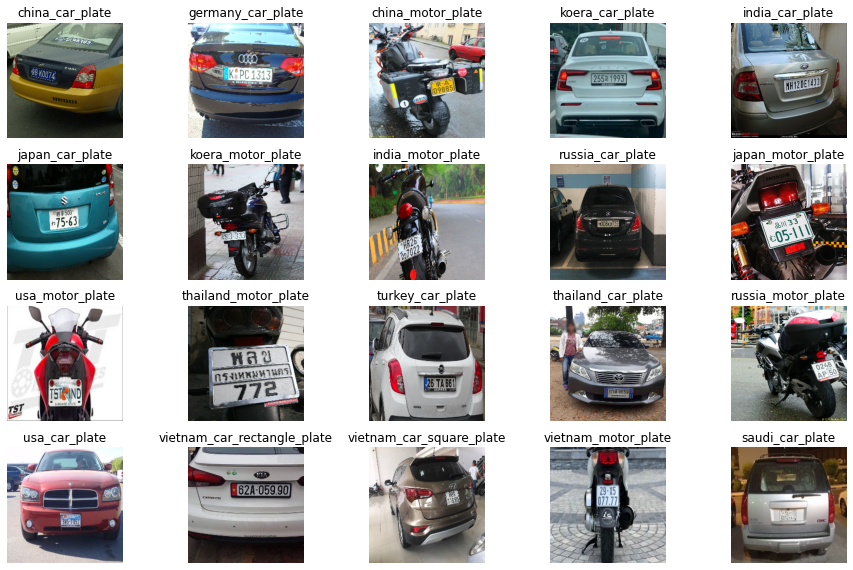

In [10]:
# Create a list of image paths 
image_paths = glob.glob("/content/gdrive/MyDrive/Plate_examples/*.*")
print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 4
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

Detect 1 plate(s) in china_motor_plate
Coordinate of plate(s) in image: 
 [array([[223.86655307, 311.82148178, 325.61118621, 237.6562575 ],
       [270.01140321, 241.25115529, 301.91970173, 330.67994966],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


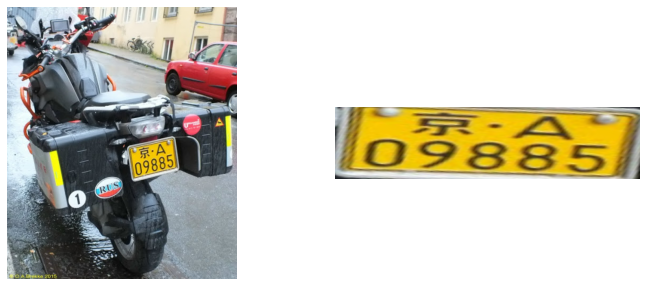

In [11]:
# forward image through model and return plate's image and coordinates
# if error "No Licensese plate is founded!" pop up, try to adjust Dmin
def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

# Obtain plate image and its coordinates from an image
test_image = image_paths[2]
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

#plt.savefig("part1_result.jpg",dpi=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


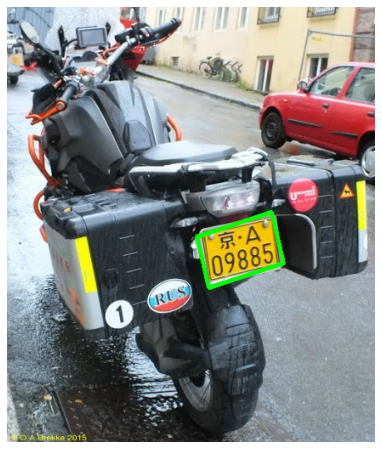

In [12]:
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

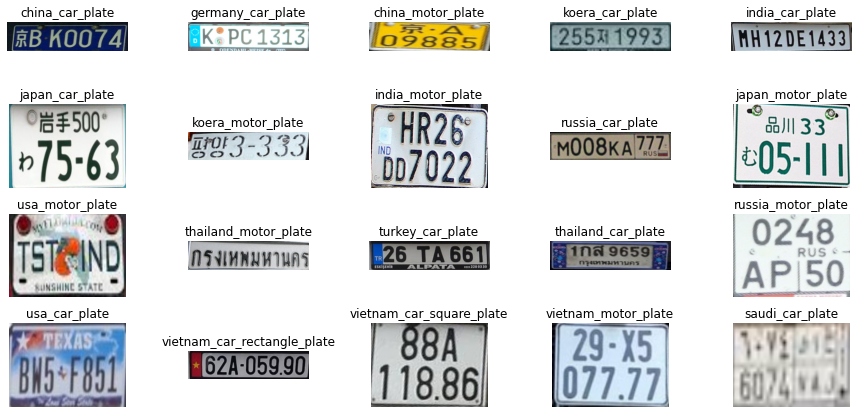

In [13]:
# Viualize all obtained plate images 
fig = plt.figure(figsize=(12,6))
cols = 5
rows = 4
fig_list = []

for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    LpImg,_ = get_plate(image_paths[i])
    plt.axis(False)
    plt.imshow(LpImg[0])

plt.tight_layout(True)
plt.show()

Detect 2 plate(s) in multiple_plates


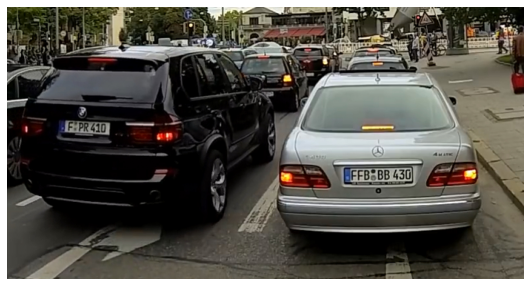

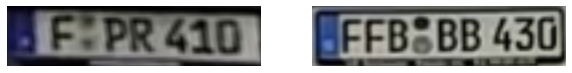

In [14]:
multiple_plates_image = "multiple_plates.png"
LpImg,cor = get_plate(multiple_plates_image)

print("Detect %i plate(s) in"%len(LpImg),splitext(basename(multiple_plates_image))[0])

# Visualize the original image
plt.figure(figsize=(10,5))
plt.axis(False)
plt.imshow(preprocess_image(multiple_plates_image))

# Visualize the obtained plates
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(LpImg[1])
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])